## Quantitative Finance Assignment 3
- Rishi Dey Chowdhury, MB2320

### Part B
Each student is reguired to select a stock from the NIFTY 50 index and collect the daily stock prices of the selected stock for at least 100 days, say $S_o,S_1\dots$. It must be ensured that no two student use the same set of data. Consider a market consisting of two assets only, namely the selected stock and the risk-free cash Bond. The interest rate on the cash bond may be assumed to be constant, which needs to be identified by students based on the current market situation (justifying the choice).

Suppose that a European Call option is available based on the selected stock having maturity time $T = f(\text{roll number})$ days and strike price $K =5T + S_0$, where $f$ is a function defined in the R-Code given below (converted it to Python).

### Import Necessary Libraries

In [693]:
# miscellaneous
from tqdm import tqdm

# data handling
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# data collection
import yfinance as yf

# QQ-plot
import scipy.stats as stats

# Normal CDF
from statistics import NormalDist

# optimization
from scipy import optimize

### Load Data

For this Assignment, I chose `TATAMOTORS`, one of the stocks of `NIFTY 50 Index` listed on Indian `National Stock Exchange` from $1^{st}$ January $2022$ to $2^{nd}$ December $2024$.

In [108]:
data = yf.download("TATAMOTORS.NS", start="2022-01-01")
time = data.index
S = data['Adj Close'].to_numpy().squeeze()

[*********************100%***********************]  1 of 1 completed


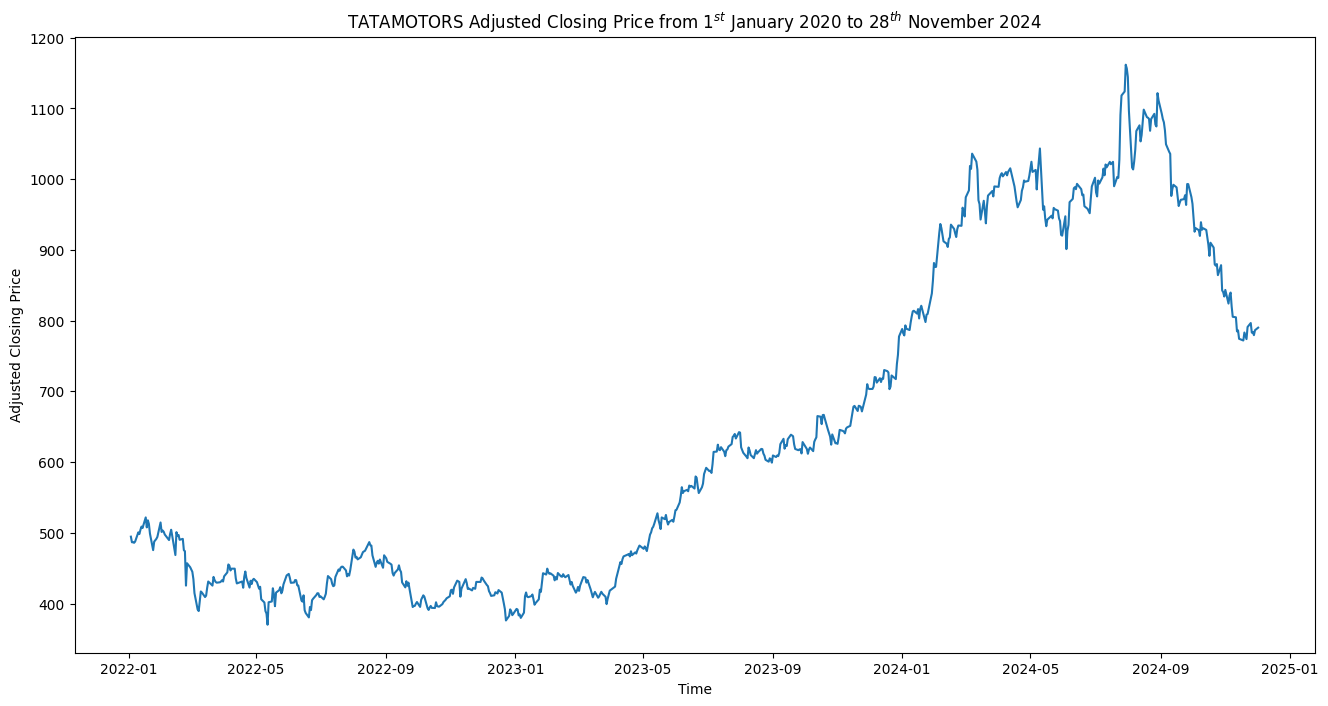

In [109]:
plt.figure(figsize=(16,8))
plt.title('TATAMOTORS Adjusted Closing Price from $1^{st}$ January 2020 to $28^{th}$ November 2024')
plt.plot(time, S)
plt.ylabel('Adjusted Closing Price')
plt.xlabel('Time')
plt.show()

#### Question a
Fit the selected data on share price by a suitable Geometric Brownian motion. (Students do not need to check for the model fit)

The Geometric Brownian Motion is given by,
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
with the following solution,
$$S_T = S_0\cdot\exp\{(\mu - \frac{1}{2}\sigma^2)T + \sigma\sqrt{T}\cdot W_T\}$$
This implies that the distribution of the GBM at time T is lognormally distributed as,
$$\ln(S_T)\sim \mathcal{N}(\ln(S_0) + (\mu - \frac{1}{2}\sigma^2)T, \sigma^2T)$$
Now by independent increment property of the Weiner's Process $\{W_t\}$, we can say that $S_t$ also has independent increments. We now observe that if $S_0 = S_t$ for some $t^{th}$ day and $T = t+1$ then,
$$\ln(S_{t+1}) - \ln(S_t)\sim^{iid} \mathcal{N}((\mu - \frac{1}{2}\sigma^2), \sigma^2) \enspace \forall t = 0, 1, \dots, N$$
This means that the daily log returns follows iid normal observations with mean $\mu - \frac{1}{2}\sigma^2$ and variance $\sigma^2$ under GBM Model. 
We can therefore use the average of the log returns and its variance to estimate the mean and variance terms (viz. the Maximum Likelihood Estimators for true mean and variance of the normal distribution) as follows,
$$\hat{\mu} - \frac{1}{2}\hat{\sigma^2} = \frac{1}{N}\sum_{t=1}^N R_t = \bar{R}_N,\enspace\text{where }R_t = \ln(\frac{S_{t}}{S_{t-1}})$$
$$\hat{\sigma^2} = \frac{1}{N-1}\sum_{t=1}^N (R_t - \bar{R}_N)^2$$
Here $N$ refers to the last index of our price series $\{S_t\}_{t=0}^N$.

So, before I use GBM for modelling the stock's log returns. I perform some exploratory data analysis to observe the nature of the log returns.

In [110]:
logreturns = np.log(S[1:]) - np.log(S[:-1])

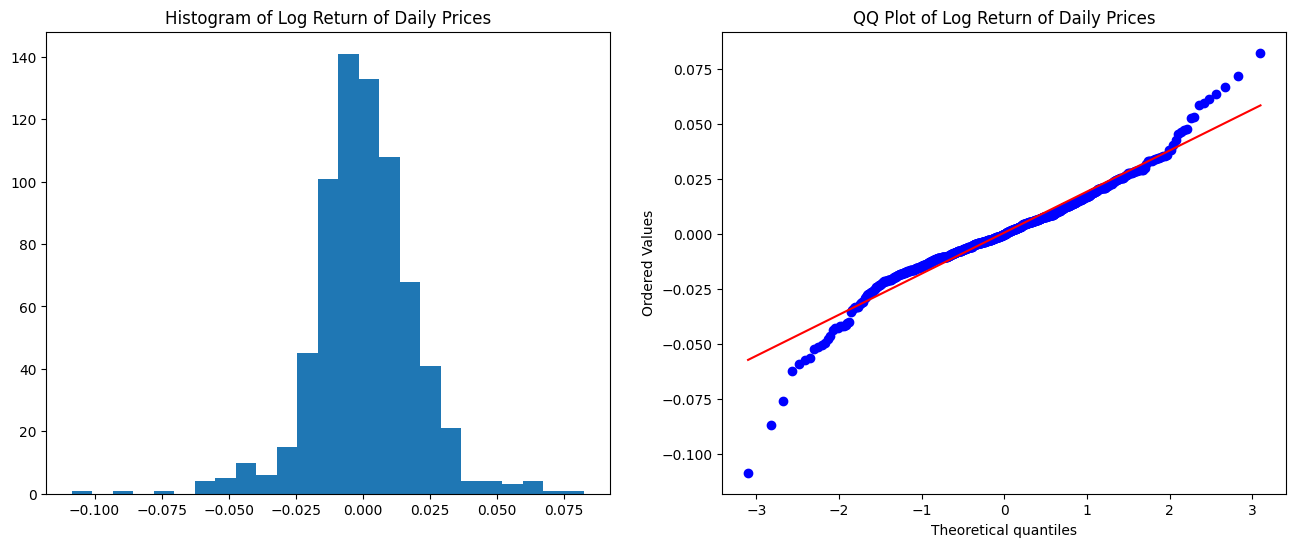

In [111]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].hist(logreturns, bins=25)
ax[0].set_title('Histogram of Log Return of Daily Prices')

stats.probplot(logreturns, dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot of Log Return of Daily Prices')
plt.show()

We observe that the log returns are approximately normally distributed from the histogram. The QQ plot indicates that the distribution is fat-tailed compared to normal distribution viz. usually observed for financial price data.

Next, I will estimate the parameters of our GBM.

In [112]:
sigma2_hat = np.var(logreturns)
mu_hat = np.mean(logreturns) + 0.5 * sigma2_hat
print('Estimated Mu:', mu_hat)
print('Estimated Sigma^2:', sigma2_hat)

Estimated Mu: 0.0008334717587135345
Estimated Sigma^2: 0.0003619498550882607


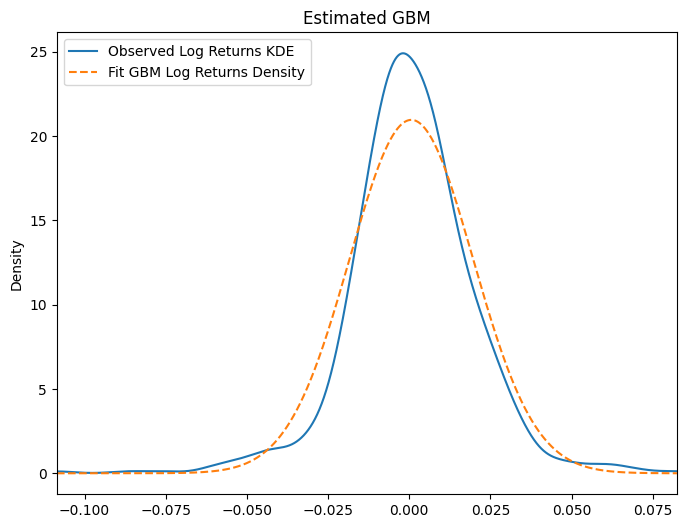

In [113]:
pd.DataFrame({'Observed Log Returns KDE': logreturns}).plot.density(ind=10000, figsize=(8,6))
plt.plot(np.linspace(np.min(logreturns), np.max(logreturns), 10000), 1/np.sqrt(2*np.pi*sigma2_hat) * np.exp(-1/(2*sigma2_hat) * (np.linspace(np.min(logreturns), np.max(logreturns), 10000) - (mu_hat - 0.5*sigma2_hat))**2), '--', label='Fit GBM Log Returns Density')
plt.title('Estimated GBM')
plt.legend()
plt.xlim(np.min(logreturns), np.max(logreturns))
plt.show()

It is not common to use daily volatility $\sigma$ and mean $\mu$ as it is. So, I annualize them assuming that there are $252$ trading days.
$$\hat{\mu}_{annualized} = \hat{\mu}\times252$$
$$\hat{\sigma}_{annualized} = \hat{\sigma}\times\sqrt{252}$$

In [114]:
mu_annual = mu_hat * 252
sigma_annual = np.sqrt(sigma2_hat * 252)
print('The Annualized Estimate of Mean Log Return:', round(mu_annual * 100, 2), '%')
print('The Annualized Estimate of Volatility Log Return:', round(sigma_annual * 100, 2), '%')

The Annualized Estimate of Mean Log Return: 21.0 %
The Annualized Estimate of Volatility Log Return: 30.2 %


#### Question b
Compute the fair price of the Call option assuming the Black-Scholes model with the parameter values estimated in (a). Also, derive a Delta-hedged replicating portfolio for this derivative under the Black-Scholes model.

Here, I first calculate the Time to Expiry ($T$) and Strike Price ($K$) using the function provided.

$$T = f(\text{roll number})\text{ days},\enspace K = 5T + S_0$$
where $f$ is provided below. Later it was later clarified that $S_0$ in the above formula should be taken as $S_N$ i.e. the last price in our series and the price of the call option of that day is to be reported.

In [115]:
# Function to calculate strike price and expiry based on roll number.
# Roll number must be entered in a valid format, namely MB2314 or MD1234.
def f(roll_number):
    roll_number = roll_number.upper()
    last_two_digits = int(roll_number[-2:])
    value = None
    if roll_number[1] == 'B':
        value = 2 * (last_two_digits % 10) + last_two_digits
    elif roll_number[1] == 'D':
        value = last_two_digits
    else:
        print('Make sure you have entered your actual roll number; there seems to be an error.')
    return value

In [694]:
T = f('MB2320')
K = 5*T + S[-1]
print('Time to Expiry (T):', T, 'days')
print('Strike Price (K):', K, 'INR')

Time to Expiry (T): 20 days
Strike Price (K): 890.0499877929688 INR


The Black-Scholes Model uses $T$ expressed in years. Since, here $T$ is provided in days, I divide it by $252$ (total number of trading days) to express it in years.
$$T = \frac{f(\text{roll number})}{252}$$

In [695]:
T = T/252

We also need the risk-free cash bond's force of interest ($r$) to compute the call option price using the Black-Schole's Model. I assume that the stock is non-dividend paying. 

For India, we have $\approx 6.5\%$ (on 28th November 2024) p.a. paid semi-annually i.e. twice a year. We calculate $r$ using the following,
$$r = \ln(1+\frac{0.065}{2})^2$$

In [696]:
r = np.log((1 + (6.5/100) / 2)**2)
print('The risk-free force of interest on Cash Bond:', round(r, 5) * 100, '%')

The risk-free force of interest on Cash Bond: 6.397 %


The Black-Scholes Formula for computing the price of call option $f(t,s)$ at time, $t$ given that the current share price is $S_t$, the time of maturity is $T > t$ and the exercise price is $K$ is,
$$f(t, S_t) = S_t\Phi(d_1) - Ke^{-r(T-t)}\Phi(d_2)$$
$$d_1 = \frac{\ln(S_t/K) + (r + \sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2 = d_1 - \sigma\sqrt{T-t}$$
where $\Phi(.)$ is the standard normal cdf, $\sigma$ is the volatility of the underlying share.

In [697]:
def blackscholes(st, K, T, r = r, t = 0):
    d1 = (np.log(st / K) + (r + 0.5 * sigma_annual**2) * (T-t)) / np.sqrt(sigma_annual**2 * (T-t))
    d2 = d1 - sigma_annual * np.sqrt((T-t))
    call_price = st * NormalDist().cdf(d1) - K * np.exp(-r*(T-t))*  NormalDist().cdf(d2)
    return call_price, NormalDist().cdf(d1), - K * np.exp(-r*(T-t))*  NormalDist().cdf(d2)

The call option price with strike $K = 890.05$ INR with maturity in $T = 20$ days on $t=N$ i.e. $2^{nd}$ December 2024 is computed below,

In [181]:
call_price, call_delta, call_cash = blackscholes(S[-1], K, T)
print('Date:', time[-1].date())
print(f'Call Option Price with T={round(T*252)} days, K = {round(K, 4)} INR: {round(call_price, 4)} INR')
print(f'Underlying Stock Price: {round(S[-1], 4)} INR')

Date: 2024-12-02
Call Option Price with T=20 days, K = 890.05 INR: 2.9651 INR
Underlying Stock Price: 790.05 INR


Since, the call option is currently out of money (OTM), the entire price is attributed to the volatility of the stock i.e. the chance that the underlying stocks moves up and ends up in the money (ITM) at expiry.

The delta of the above call option is the measure of the instantaneous change in the derivative's price given the instantaneous change in the underlying stock's price and is given by the following for non-dividend paying stock (I assume our stock to be non-dividend paying),
$$\Delta_t = \frac{\partial f(t, S_t)}{\partial S_t} = \Phi(d_1)$$
Note: $d_1$ is a function of $S_t$.

We will use this to compute the replicating portfolio for the call option at time $t$ viz. given by the previsible process $(\phi_t, \psi_t)$, where

- $\phi_t =$ number of units of stock to hold over the infinitesimally small time interval from $t$ to $t+\delta t$.

- $\psi_t =$ number of units of cash bond to hold over the infinitesimally small time interval from $t$ to $t+\delta t$.

$$\phi_t = \Phi(d_1) = \Delta_t, \psi_t = -Ke^{r(T-t)}\Phi(d_2)$$
It can be proved using the Martingale Approach.

The overall delta of a portfolio (say, $P$) consisting of *buying a replicating portfolio and selling a call option or vice-versa* is $\pm1\times\Delta_t \mp \Delta_t\times1 = 0$ (since, underlying has $\Delta = \frac{\partial S_t}{\partial S_t} = 1$) and hence $P$ is called the **Delta-hedged Portfolio**.

Below, I have stated the replicating portfolio at time $t=N$ i.e. $2^{nd}$ December 2024.

In [198]:
print(f'Replicating Portfolio for the 1 Call option on {time[-1].date()}:')
print('Number of Stocks:', round(call_delta, 4))
print('Number of Cash Bonds:', round(call_cash, 4))

Replicating Portfolio for the 1 Call option on 2024-12-02:
Number of Stocks: 0.097
Number of Cash Bonds: -73.7061


##### Monte-Carlo Simulation
This is an additional experiment, I performed to see how close the call option's price is to the Black-Scholes price via Monte-Carlo simulation.

The starting point is taking the Geometric Brownian Motion equation for the underlying stock $S_t$:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
where we have set $\mu = r/252$, since we are working in a risk-free setting and use the daily estimates in the above expression. The solution yields,
$$S_T = S_0\cdot\exp\{(\frac{r}{252} - \frac{1}{2}\sigma^2)T + \sigma\sqrt{T}\cdot W_T\}$$
Now, I simulate the underlying stock's price in this risk free setting below,

In [ ]:
num_sims = 1000000
sims = np.array([np.array([S[-1]] + list(np.exp(np.log(S[-1]) + np.random.normal(r/252 - 0.5 * sigma2_hat, np.sqrt(sigma2_hat), 20).cumsum()))) for _ in range(num_sims)])

2.9616190875926613

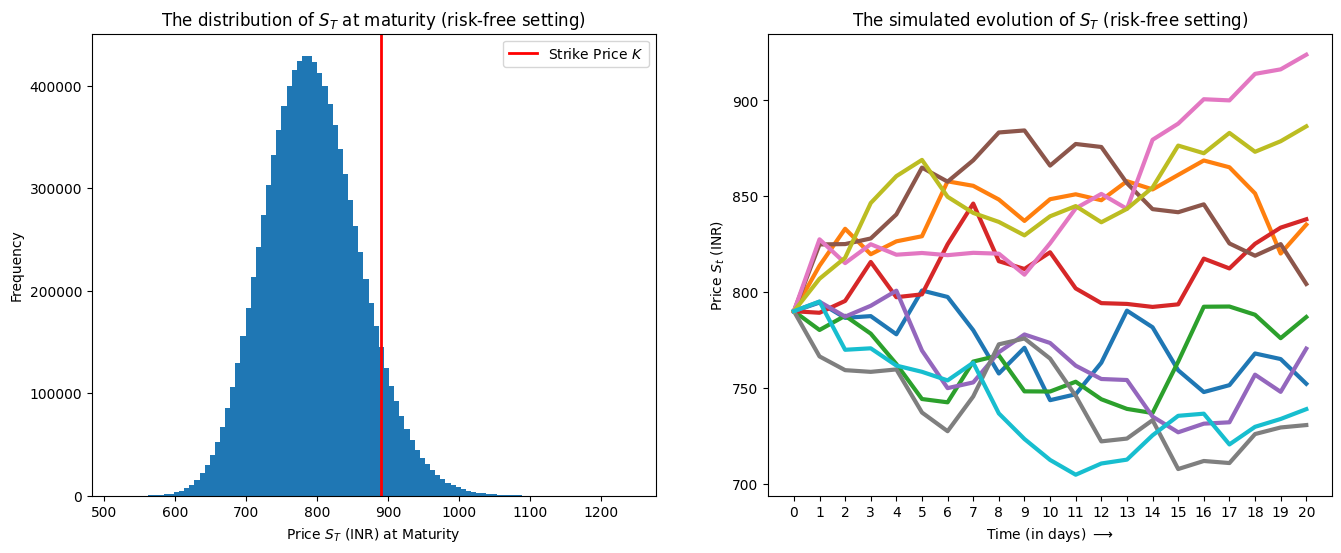

In [603]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(sims[:,-1], bins=100)
ax[0].set_title('The distribution of $S_T$ at maturity (risk-free setting)')
ax[0].set_xlabel('Price $S_T$ (INR) at Maturity')
ax[0].set_ylabel('Frequency')
ax[0].axvline(K, color='red', linewidth=2, label='Strike Price $K$')
ax[0].legend()

ax[1].plot(sims[:10].T, linewidth=3)
ax[1].set_title('The simulated evolution of $S_T$ (risk-free setting)')
ax[1].set_xlabel('Time (in days) $\longrightarrow$')
ax[1].set_ylabel('Price $S_t$ (INR)')
ax[1].set_xticks(list(range(21)), [f'{k}' for k in range(21)])
plt.show()

We know that, in the case of a call option, the payoff function at maturity $T$ is given by:
$$\
h(S_{T}) = \max \left( S_{T}-X,0\right)\,.
$$
Then, in the particular case of a risk-free setting, it can be shown that the call option price is given by:
$$
C(T)  = e^{-r(T-t)}\int_{-\infty}^{\infty}dS_{T}\,h(S_{T})\,q(S_{T})\,,
$$
where $q(S)$ is a probability density for the equivalent martingale process to $S_{t}$. This integral can actually be discretized, yielding:
$$
C(T) = e^{-r(T-t)}\frac{1}{I}\sum_{i = 1}^{I}h(S_{T}^{i})\,,
$$
where the sum is taken over a collection $S_{T}^{i}$ following a geometric brownian motion that can be generated by Monte Carlo simulation i.e. the final price of the underlying at time $T$ from $i^{th}$ simulated price path as shown in the RHS figure above.

In [604]:
print('Date:', time[-1].date())
print(f'Call Option Price with T={round(T*252)} days, K = {round(K, 4)} INR: {round(np.exp(-r*T) * np.maximum(sims[:,-1] - K, 0).mean(), 4)} INR')

Date: 2024-12-02
Call Option Price with T=20 days, K = 890.05 INR: 2.9716 INR


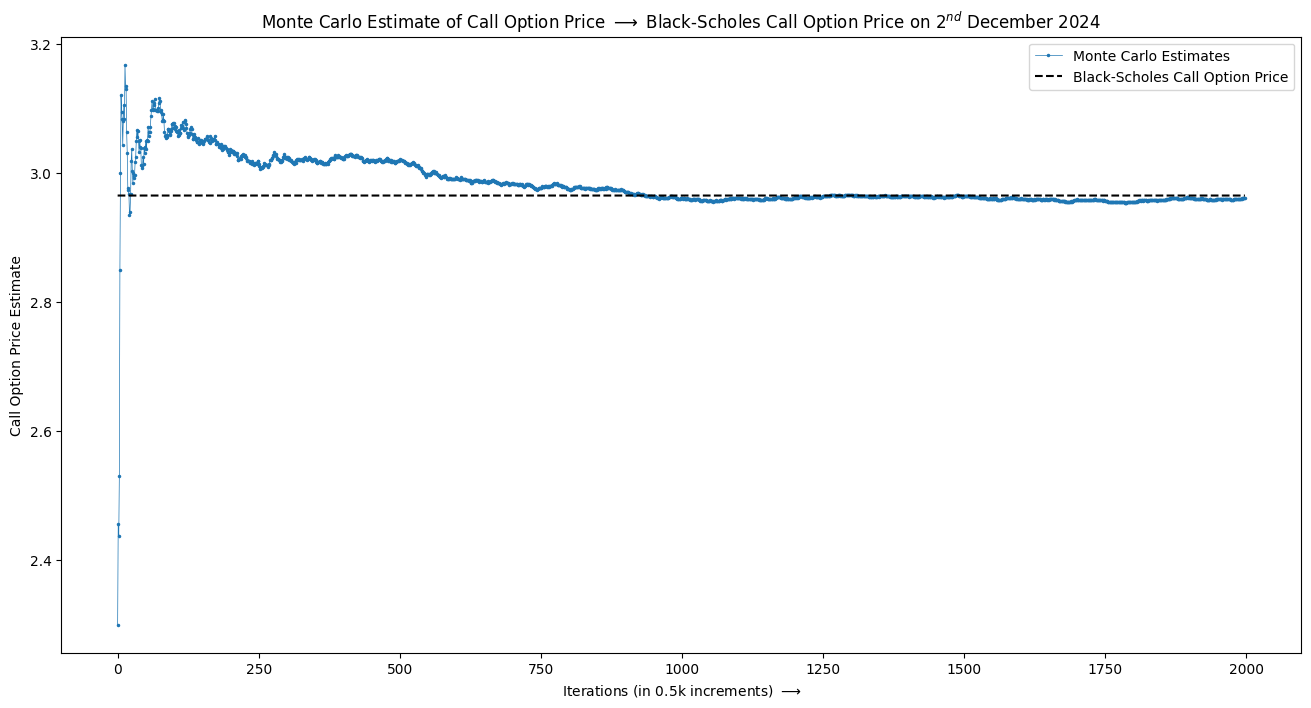

In [692]:
plt.figure(figsize=(16,8))
plt.plot([np.exp(-r*T) * np.maximum(sims[:k,-1] - K, 0).mean() for k in range(500, num_sims, 500)], '-o', linewidth=0.5, markersize=1.5, label='Monte Carlo Estimates')
plt.plot([call_price] * len(range(500, num_sims, 500)), '--k', label='Black-Scholes Call Option Price')
plt.title('Monte Carlo Estimate of Call Option Price $\longrightarrow$ Black-Scholes Call Option Price on $2^{nd}$ December 2024')
plt.xlabel('Iterations (in 0.5k increments) $\longrightarrow$')
plt.ylabel('Call Option Price Estimate')
plt.legend()
plt.show()

Clearly, the Monte-Carlo estimate converges to the Black-Scholes call option price as we increase the number of interations as can be seen above.

#### Question c
Compute the fair price of the Call option assuming an Binomial lattice model with sub-interval length $\Delta t=1$ days. The parameter values must be obtained by matching the means and variance of the underlying share with those obtained under the Black-Scholes model. Also, derive a Delta-hedged replicating portfolio for this derivative under the present binomial model.

I will use the Recombining Binomial Tree Option Pricing Model here for its computational efficiency. Here the size of the up-steps and down-steps are the same in all states i.e.
$$u_t(j) = u, d_t(j) = d\enspace\forall t, j$$
This implies that $$q_t(j) = q\enspace\forall t, j, 0 < q < 1$$ i.e. the probability of an upward step is also constant.

Since, we assume that there does not exist any arbitrage we must have,
$$d < e^r < u$$

To calibrate the recombining binominal model, we make an additional assumption that $$u = \frac{1}{d}$$
i.e. an up-step and down-step would mean the share price, after two steps, is the same as it is at time 0.

Now from part (a) we have assumed that the price process follows GBM. If we parameterize the lognormal distribution (under the risk) so that,
$$\ln(\frac{S_t}{S_{t_0}})\sim\mathcal{N}((r-\frac{\sigma^2}{2})(t-t_0), \sigma^2(t-t_0))$$
then the conditions that must be met are,
$$E[\frac{S_{t+\Delta t}}{S_t}] = e^{r\Delta t}$$
$$Var[\frac{S_{t+\Delta t}}{S_t}] = \sigma^2\Delta t$$
where,

- $\Delta t$ is the time interval of each step in the binomial model.

- $S_t$ denotes the price of the asset at time t.

Now, we note that
$$E[\frac{S_{t+\Delta t}}{S_t}] = qu + (1-q)d$$
From the above expression, we get,
$$q = \frac{\exp(r\Delta t) - d}{u-d}$$

And from the variance expression and the additional assumption of $u = 1/d$, we have,
$$Var[\ln(\frac{S_{t+\Delta t}}{S_t})] = q\cdot\ln(u)^2+ (1-q)\cdot(-\ln(u))^2 - E[\ln(\frac{S_{t+\Delta t}}{S_t})]^2 = (\ln(u))^2 - E[\ln(\frac{S_{t+\Delta t}}{S_t})]^2$$
The last term involves terms of higher order than $\Delta t$. Using the lognormal distribution we stated above, we can see that,
$$E[\ln(\frac{S_{t+\Delta t}}{S_t})]^2 = (r-\frac{\sigma^2}{2})^2\Delta t^2\longrightarrow 0\enspace\text{if }\Delta t\rightarrow 0$$
So, if we ignore the second term then, we get,
$$Var[\ln(\frac{S_{t+\Delta t}}{S_t})] = (\ln(u))^2 = \sigma^2\Delta t$$
Solving this, we end up with,
$$u = e^{\sigma\sqrt{\Delta t}}, d = e^{-\sigma\sqrt{\Delta t}}$$

Below, I estimate these parameters from the $\hat{\sigma}$ which we estimated earlier in part (a) and used in the Black-Scholes Formula in part (b).

In [185]:
dt = 1/252 # expressed as years
u = np.exp(sigma_annual * np.sqrt(dt))
d = np.exp(-sigma_annual * np.sqrt(dt))
q = (np.exp(r*dt) - d) / (u-d)
print(f'Upward Step Size (u): {round(u, 4)}')
print(f'Downward Step Size (d): {round(d, 4)}')
print(f'Upward Step Probability (q): {round(q, 4)}')

Upward Step Size (u): 1.0192
Downward Step Size (d): 0.9812
Upward Step Probability (q): 0.5019


The fact that $q\in(0, 1)$ implies that the no arbitrage condition $d < e^{r\Delta t} < u$ is satisfied.

Now, to compute the price of the call option at time $t$ from the recombining binomial tree we use the following formula,
$$V_t(S_t) = e^{-r(T-t)}\cdot\sum_{k=0}^{n - t} f(S_tu^kd^{n - t - k}){{n - t}\choose k}q^k(1-q)^{n-t-k}$$
$$n = \frac{T}{\Delta t}, f(x) = \max(x-K, 0)$$
I assume that $\Delta t$ divides $T$.

Just like we did in part (b), since the $t$ is not provided we take $t = 0,1,\dots,N$ and $T$ is the time of maturity of a call option starting from $t$ and compute the price of the call option using the recombining binomial tree model. 

In [186]:
def recomb_bintree(st, K, T, r = r, t = 0):
    n = round(np.ceil(T/dt))
    Vt = np.exp(-r*(T-t)) * np.sum([max(st * (u**k) * (d**(n-t-k)) - K, 0) * stats.binom.pmf(k, n-t, q) for k in range(n-t+1)])
    return Vt

The call option price with strike $K = 890.05$ INR with maturity in $T = 20$ days on $t=N$ i.e. $2^{nd}$ December 2024 is computed below,

In [187]:
binom_call_price = recomb_bintree(S[-1], K, T)
print('Date:', time[-1].date())
print(f'Call Option Price with T={round(T*252)} days, K = {round(K, 4)} INR: {round(binom_call_price, 4)} INR')
print(f'Underlying Stock Price: {round(S[-1], 4)} INR')

Date: 2024-12-02
Call Option Price with T=20 days, K = 890.05 INR: 2.8292 INR
Underlying Stock Price: 790.05 INR


The replicating portfolio for the call option at time $t$, using a recombining binomial tree model, is given by the previsible process $(\phi_{t+\Delta t}(S_t), \psi_{t+\Delta t}(S_t))$, where the stock price at time $t$ is $S_t$ and 

- $\phi_{t+\Delta t}(S_t) =$ number of units of stock to hold over the time interval from $t$ to $t+\Delta t$.

- $\psi_{t+\Delta t}(S_t) =$ number of units of cash bond to hold over the time interval from $t$ to $t+\Delta t$.

$$\phi_{t+\Delta t}(S_t) = \frac{V_{t+\Delta t}(u\cdot S_t) - V_{t+\Delta t}(d\cdot S_t)}{S_t\cdot(u-d)}, \psi_{t+\Delta t}(S_t) = e^{-r\Delta t}\cdot\frac{V_{t+\Delta t}(d\cdot S_t)\cdot u - V_{t+\Delta t}(u\cdot S_t)\cdot d}{u-d}$$
where $V_{t+\Delta t}(u\cdot S_t)$ is the price of the call option starting at time $t+\Delta t$ with the price of the underlying at $t+\Delta t$ being $u\cdot S_t$. Similarly, $V_{t+\Delta t}(d\cdot S_t)$ where the price of the underlying at $t + \Delta t$ is $d\cdot S_t$.

In [192]:
bin_num_stocks = (recomb_bintree(S[-1]*u, K,T - dt) - recomb_bintree(S[-1]*d, K,T - dt)) / (S[-1] * (u - d))
bin_num_cash = np.exp(-r*dt) * (recomb_bintree(S[-1]*d, K, T - dt) * u - recomb_bintree(S[-1]*u, K, T - dt) * d) / (u - d)

print(f'Replicating Portfolio for the 1 Call option on {time[-1].date()}:')
print('Number of Stocks:', bin_num_stocks)
print('Number of Cash Bonds:', bin_num_cash)

Replicating Portfolio for the 1 Call option on 2024-12-02:
Number of Stocks: 0.09212569894433853
Number of Cash Bonds: -69.95471050791157


####  Question d
Repeat the exercise in part (c) with decreasing values of $\Delta t$ to show that the option price as well as the replicating portfolio obtained under the binomial model converge to the same obtained under the Black-Scholes model in part (b) as $\Delta t\rightarrow 0$.

Below, I have shown the convergence of the Recombining Binomial Tree's estimated call option price on $2^{nd}$ December 2024 to that of the Black-Scholes Model for decreasing $\Delta t$ in particular I took $\Delta t = \frac{1}{k},\enspace k=1,\dots,200$.

In [193]:
binom_call_prices_conv = {round(dt,5): 0 for dt in [1/k for k in range(1, 200)]}
binom_num_stocks = {round(dt,5): 0 for dt in [1/k for k in range(1, 200)]}
binom_num_cash = {round(dt,5): 0 for dt in [1/k for k in range(1, 200)]}

for dt in tqdm(binom_call_prices_conv):
    dt = dt/252
    u = np.exp(sigma_annual * np.sqrt(dt))
    d = np.exp(-sigma_annual * np.sqrt(dt))
    q = (np.exp(r*dt) - d) / (u-d)

    def recomb_bintree(st, K, T, r = r, t = 0):
        n = round(np.ceil(T/dt))
        Vt = np.exp(-r*(T-t)) * np.sum([max(st * (u**k) * (d**(n-t-k)) - K, 0) * stats.binom.pmf(k, n-t, q) for k in range(n-t+1)])
        return Vt

    binom_call_prices_conv[round(dt*252,5)] = recomb_bintree(S[-1], K, T)
    binom_num_stocks[round(dt*252,5)] = (recomb_bintree(S[-1]*u, K,T - dt) - recomb_bintree(S[-1]*d, K,T - dt)) / (S[-1] * (u - d))
    binom_num_cash[round(dt*252,5)] = np.exp(-r*dt) * (recomb_bintree(S[-1]*d, K, T - dt) * u - recomb_bintree(S[-1]*u, K, T - dt) * d) / (u - d)

 54%|█████▍    | 107/199 [00:23<00:39,  2.35it/s]/Users/rishideychowdhury/Desktop/Option-Pricing/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
100%|██████████| 199/199 [01:18<00:00,  2.52it/s]


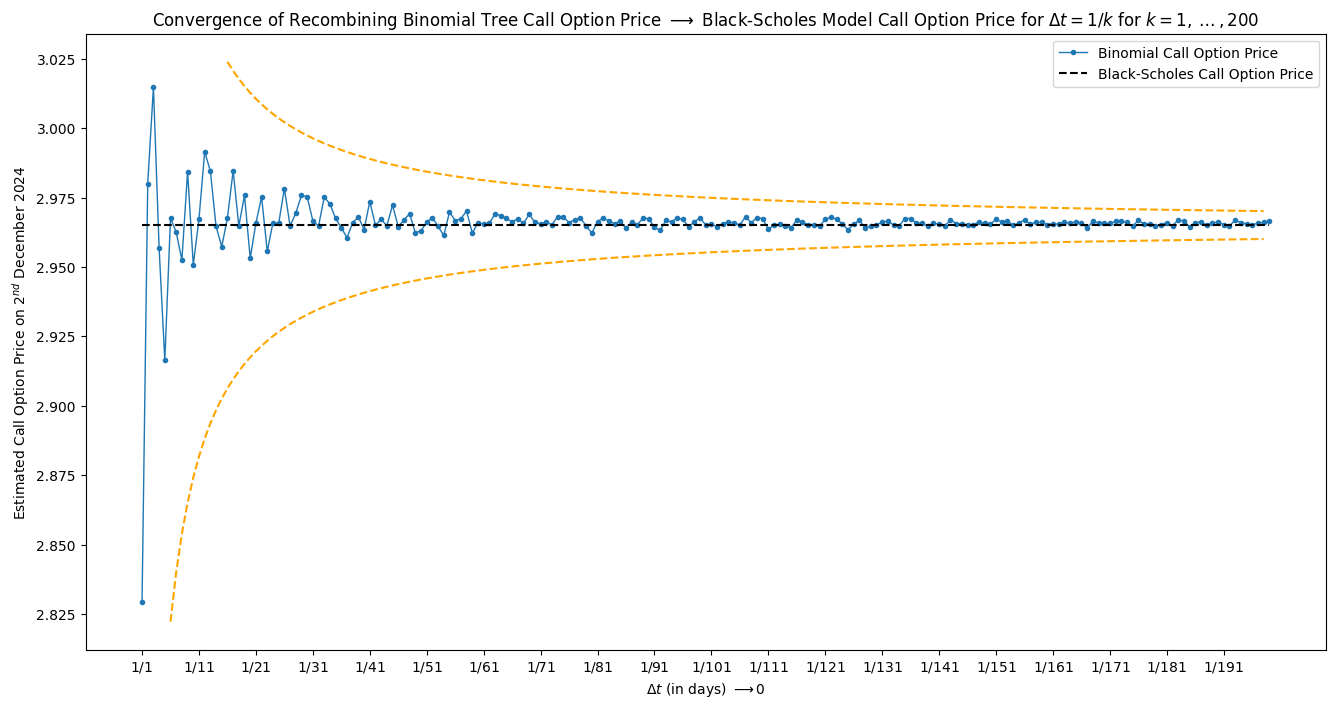

In [224]:
plt.figure(figsize=(16,8))
plt.plot(np.array(list(binom_call_prices_conv.values())), '-o', linewidth=1, markersize=3, label='Binomial Call Option Price')
plt.plot([call_price] * len(binom_call_prices_conv), '--k', label='Black-Scholes Call Option Price')
plt.plot([np.nan]*15 + list(np.array([1/k for k in range(17, 200)])+call_price), '--', color='orange')
plt.plot([np.nan]*5 + list(np.array([-1/k for k in range(7, 200)])+call_price), '--', color='orange')
plt.title('Convergence of Recombining Binomial Tree Call Option Price $\longrightarrow$ Black-Scholes Model Call Option Price for $\Delta t = 1/k$ for $k=1,\dots,200$')
plt.xticks(list(range(0,200,10)), [f'$1/{k}$' for k in range(1,200,10)])
plt.xlabel('$\Delta t$ (in days) $\longrightarrow 0$')
plt.ylabel('Estimated Call Option Price on $2^{nd}$ December 2024')
plt.legend()
plt.show()

It is clear that the sequence of call option price estimated using the recombining binomial tree converges to the Black-Scholes estimated Call Option price as $\Delta t\rightarrow 0$. The convergence rate looks similar to the rate at which $\Delta t\rightarrow 0$ (i.e. $\frac{1}{n}$ in this case) as shown by the dotted boundary lines on either sides.

I have shown below the convergence of the Recombining Binomial Tree's estimated replicating portfolio on $2^{nd}$ December 2024 to that of the Black-Scholes Model for decreasing $\Delta t$ in particular I took $\Delta t = \frac{1}{k},\enspace k=1,\dots,200$.

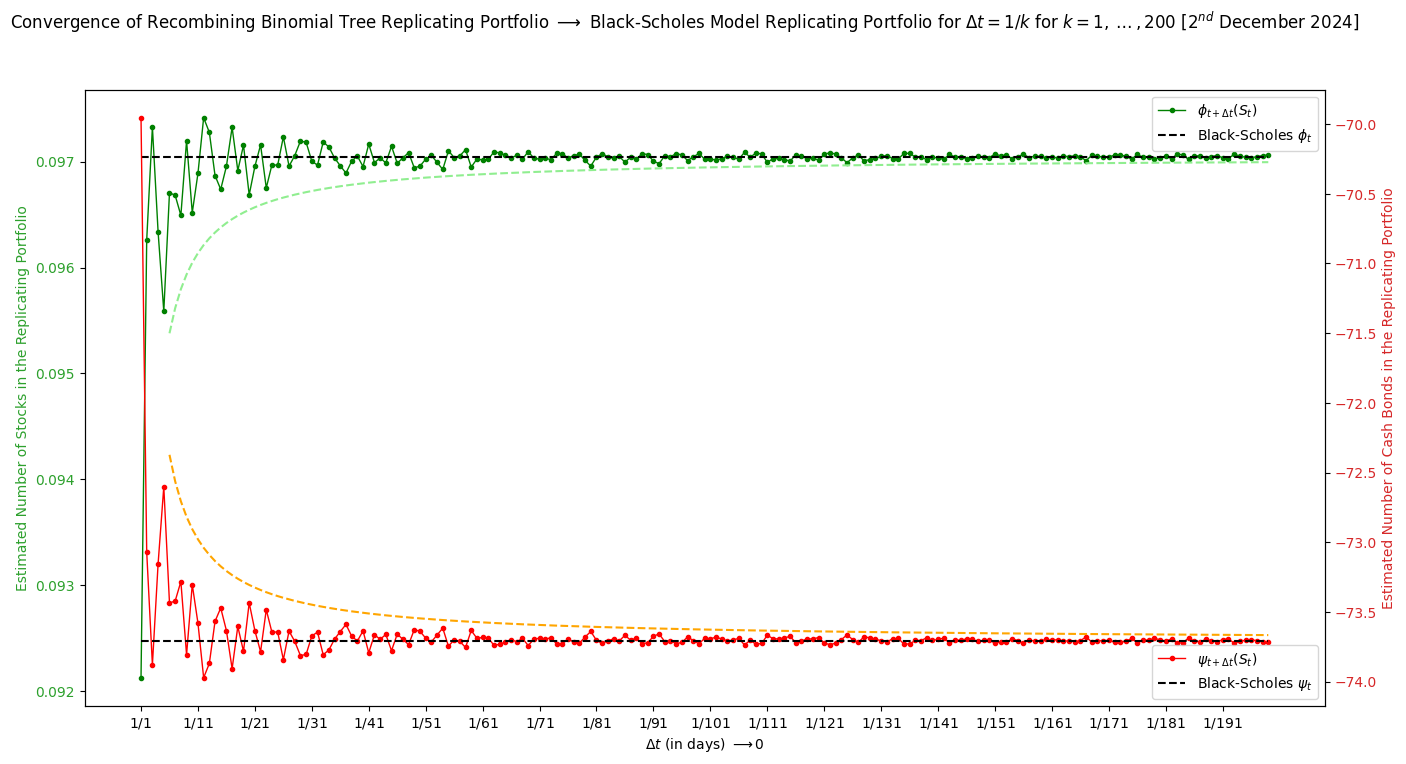

In [226]:
fig, ax1 = plt.subplots(figsize=(16, 8)) 
# plt.plot(data.close[:21])
ax1.plot(np.array(list(binom_num_stocks.values())), '-o', linewidth=1, markersize=3, color='green', label='$\phi_{t+\Delta t}(S_t)$')
ax1.plot([call_delta] * len(binom_num_stocks), '--k', label='Black-Scholes $\phi_t$')
ax1.plot([np.nan]*5 + list(np.array([-1e-2/k for k in range(6, 200)])+call_delta), '--', color='lightgreen')
ax1.legend()
ax1.set_xticks(list(range(0,200,10)), [f'$1/{k}$' for k in range(1,200,10)])
ax1.set_xlabel('$\Delta t$ (in days) $\longrightarrow 0$')
ax1.set_ylabel('Estimated Number of Stocks in the Replicating Portfolio', color = 'tab:green')
ax1.tick_params(axis ='y', labelcolor = 'tab:green') 

ax2 = ax1.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('BNBUSDT Price', color = color) 
ax2.plot(np.array(list(binom_num_cash.values())), '-o', linewidth=1, markersize=3, color='red', label='$\psi_{t+\Delta t}(S_t)$')
ax2.plot([call_cash] * len(binom_num_cash), '--k', label='Black-Scholes $\psi_t$')
ax2.plot([np.nan]*5 + list(np.array([8/k for k in range(6, 200)])+call_cash), '--', color='orange')
ax2.legend(loc='lower right')
ax2.set_ylabel('Estimated Number of Cash Bonds in the Replicating Portfolio')
ax2.tick_params(axis ='y', labelcolor = color) 

fig.suptitle('Convergence of Recombining Binomial Tree Replicating Portfolio $\longrightarrow$ Black-Scholes Model Replicating Portfolio for $\Delta t = 1/k$ for $k=1,\dots,200$ [$2^{nd}$ December 2024]')
plt.show()

#### Question e
Comments on the convergence rate based on suitable literature review and the results obtained for your choose stock price data.

The price of the call option at time $t$ from the recombining binomial tree is given by,
$$V_t(S_t) = e^{-r(T-t)}\cdot\sum_{k=0}^{n - t} f(S_tu^kd^{n - t - k}){{n - t}\choose k}q^k(1-q)^{n-t-k}$$
$$n = \frac{T}{\Delta t}, f(x) = \max(x-K, 0)$$
I assume that $\Delta t$ divides $T$. We can find $a$ such that,
    $$ f(S_tu^kd^{n - t - k}) =   \left \{
\begin{array}{ll}
      0 & k < a \\
      S_tu^kd^{n - t - k} - K & k \ge a \\
\end{array} 
\right.  $$
So, we can eliminate these terms which contribute $0$ to the sum. This gives,
$$V_t(S_t) = e^{-r(T-t)}\cdot\sum_{k=a}^{n - t} f(S_tu^kd^{n - t - k}){{n - t}\choose k}q^k(1-q)^{n-t-k}$$
$$= e^{-r(T-t)}\cdot\sum_{k=a}^{n - t} S_tu^kd^{n - t - k}{{n - t}\choose k}q^k(1-q)^{n-t-k} -  e^{-r(T-t)}\cdot K\cdot\sum_{k=a}^{n - t} {{n - t}\choose k}q^k(1-q)^{n-t-k}$$
In a risk-neutral world, the value of the stock invested in a risk-free asset is equivalent to the value of the stock invested in the market. Formally, for a single step of the binomial model viz. $\Delta t$ time, this is,
$$e^{r\Delta t}S_t = quS_t + (1-q)dS_t\implies 1 = e^{-r\Delta t}qu + e^{-\Delta t}(1-q)d$$
So, we can take return-adjusted risk-neutral probabilities as,
$$\rho = e^{-r\Delta t}qu, 1-\rho = e^{-r\Delta t}(1-q)d$$
It is easy to note that how under this new risk-adjusted neutral probabilities, the expected value of the stock after one time period is a martingale,
$$S = \rho S + (1-\rho)S$$
Now, it is easy to note that we can take the $e^{r(T-t)}$ term inside the first sum under the re-parameterising of $q$ to $\rho$. This gives,
$$V_t(S_t) = S_t\cdot\Big\{\sum_{k=a}^{n - t} {{n - t}\choose k}\rho^k(1-\rho)^{n-t-k}\Big\} -  e^{-r(T-t)}\cdot K\cdot\Big\{\sum_{k=a}^{n - t} {{n - t}\choose k}q^k(1-q)^{n-t-k}\Big\}$$
Under the new notation defined below,
$$B(a;n,p) = 1-P[X\le x-1] = \sum_{j=x}^{n} p^j(1-p)^{n-j},\text{ where }X\sim Bin(n,p)$$
We get the option price $V_t$ in the form,
$$V_t(S_t) = S_tB(a;n-t, \rho) - Ke^{-r(T-t)}B(a;n, q)$$
Now, it can be proved using CLT that,
$$B(a;n-t, \rho)\longrightarrow^d\Phi(d_1), B(a;n, q)\longrightarrow^d\Phi(d_2),\enspace\text{as }nq\longrightarrow\infty, n\longrightarrow\infty$$
where $d_1$ and $d_2$ are same as that defined in part (b) in Black-Scholes Model. The convergence rate depends on how fast the survival probabilities denoted by $B(.;.,.)$ converge to the standard normal cdf. The condition for this convergence above is expressed in terms of $n$, which we can express in terms of $\Delta t$ as follow,
$$n\rightarrow\infty\Longleftrightarrow\frac{T}{\Delta t}\rightarrow\infty\Longleftrightarrow\Delta t\rightarrow 0$$
The exact convergence rate as empirically noted above and rigorously proved in  Leisen and Reimer (Applied Mathematical Finance, 1996) turns out to be in the order of $$\frac{1}{n}\Longleftrightarrow\Delta t$$
However, this convergence is often non-monotonic due to nonlinearity error caused by discontinuities in the option price as can be seen in the last diagram of part (d).

Since, the expression for $\phi_{t+\Delta t}(S_t)$ and $\psi_{t+\Delta t}(S_t)$ depends on $V_{t+\Delta t}(u\cdot S_t)$ and $V_{t+\Delta t}(d\cdot S_t)$. The order of convergence is also the same for the replicating portfolios.

I looked at the call option chain available for `TATA MOTORS` in the Indian National Stock Exchange at the strike price of $K\approx 890$ INR (found earlier) on $2^{nd}$ December 2024 with expiry on $26^{th}$ December 2024 (viz. roughly $18$ trading days). It is priced at $1.55$ INR. The `TATA MOTORS` stock traded at the price of $790.04$ INR on $2^{nd}$ December 2024.

In [142]:
print('Date: 2nd December 2024')
print('Black-Scholes call option price with K = 890 INR, T = 19 days:', round(blackscholes(S[-1], K, 18/252)[0], 2), 'INR')

Date: 2nd December 2024
Black-Scholes call option price with K = 890 INR, T = 19 days: 2.37 INR


We see that the estimated call option price is close to that of the actual call option price. It is even closer if we take into account the dividend rate of the stock which is roughly $1.03$% p.a. (but in that case, we use a variation of the Black-Scholes Formula i.e. the Garman-Kohlhagen Formula).

This makes us confident about the Black-Scholes Model being correctly implemented and the returns are close to what we observe in the real Indian Markets. 

One interesting piece of information we can extract from this observed price of call option is an estimate of the market's future outlook on the underlying's volatility i.e. the **implied volatility**.

In [703]:
observed_call_price = 1.55

def blackscholes1(st, K, T, sigma, r = r, t = 0):
    d1 = (np.log(st / K) + (r + 0.5 * sigma**2) * (T-t)) / np.sqrt(sigma**2 * (T-t))
    d2 = d1 - sigma * np.sqrt((T-t))
    call_price = st * NormalDist().cdf(d1) - K * np.exp(-r*(T-t))*  NormalDist().cdf(d2)
    return call_price

def error_price(opt_sigmat):
    coup_fair_price = blackscholes1(S[-1], 890, 18/252, opt_sigmat)
    return (coup_fair_price - observed_call_price)**2

res = optimize.minimize(error_price, np.array([sigma_annual]), bounds=[(1e-10, 1)], method='Nelder-Mead')

print('Date:', time[-1].date())
print('Historic Volatility (Annualized):', round(sigma_annual * 100, 2), '%')
print('Implied Volatility (Annualized):', round(res.x[0] * 100, 2), '%')

Date: 2024-12-02
Historic Volatility (Annualized): 30.2 %
Implied Volatility (Annualized): 27.41 %


So, it turns out that the market believes the future volatility of the stock is lesser than what is observed in the past. Several trading strategies exists around *volatility trading* where the trader takes a short or long position in terms of the volatility.